In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
import random

In [2]:
print(os.getcwd())

#creo lista di nomi 
directories = ['data/train/', 
               'data/val/', 
               'data/test/']

train_file_names = [f for f in listdir(directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names] 

/home/phil/Documents/FisicaUniMiB/Tesi/Source/Code


In [3]:
#numero immagini per categoria
scans = ['CT','MRI','PET']
numbers=[]
minimi=[]

for directory in directories:    
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2]==scan[:2]])
        print('Numbero di immagini', scan, 'in', directory,':', a)
        numbers.append(a)
    minimi.append(min(numbers))

#print(minimi)
#=> è sempre la PET che ha il numero minore

Numbero di immagini CT in data/train/ : 394
Numbero di immagini MRI in data/train/ : 549
Numbero di immagini PET in data/train/ : 332
Numbero di immagini CT in data/val/ : 142
Numbero di immagini MRI in data/val/ : 170
Numbero di immagini PET in data/val/ : 114
Numbero di immagini CT in data/test/ : 71
Numbero di immagini MRI in data/test/ : 86
Numbero di immagini PET in data/test/ : 57


In [4]:
#creo la lista di file bilanciata
train_final_file_names=[]
val_final_file_names=[]
test_final_file_names=[]
_final_file_names = [train_final_file_names, val_final_file_names, test_final_file_names] 

l=[]
for directory,minimo,name in zip(directories, minimi,_final_file_names):    
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2]==scan[:2]]
        random.shuffle(l)
        l = l[:minimo]
        name.extend(l) #estendo la lista (don't append)
        
# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
# 
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

In [5]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(val_final_file_names) ,", Test:", len(test_final_file_names))

DATASET
Training 996 , Validation: 342 , Test: 171


## Converto le immagini in tensori

In [6]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

### X

In [7]:
def WriteAndArrayImages(path):
    x = io.imread(path[random.randint(0,100)])
    x = cv2.resize(x, dsize=(128,128))
    
    for img in path[1:]:
        img = io.imread(img)
        img = cv2.resize(img, dsize=(128,128))
        x = np.dstack((x,img))
    x = np.rollaxis(x,-1)
    return x

(996, 128, 128)
(342, 128, 128)
(171, 128, 128)


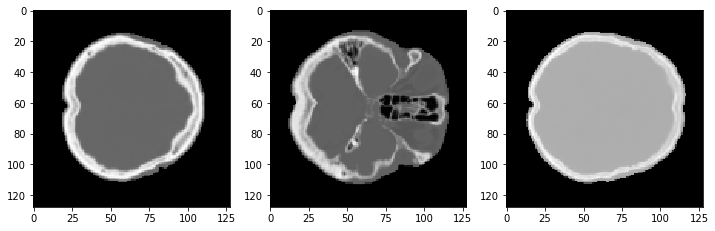

In [8]:
import numpy as np

#paths per leggere le immagini
train_paths=[]
val_paths=[]
test_paths=[]
_paths=[train_paths,val_paths,test_paths]

for path,name,directory in zip(_paths,_final_file_names,directories):
    for f in name:
        path.append(directory+f)

#leggo le immagini e le stacco una sopra l'altra
x_train = WriteAndArrayImages(train_paths)
x_val = WriteAndArrayImages(val_paths)
x_test = WriteAndArrayImages(test_paths)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#plot images from each dataset
f, axarr = plt.subplots(1,3,figsize=(12, 12))
axarr[0].imshow(x_train[random.randint(0,10)], cmap=plt.cm.gray)
axarr[1].imshow(x_val[random.randint(0,10)], cmap=plt.cm.gray)
axarr[2].imshow(x_test[random.randint(0,10)], cmap=plt.cm.gray)

### Y

In [9]:
def MakeLabels(_name_files):
    y=[]
    for text in _name_files:
        fileNameOnly = text[:text.find(ext)]
        y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
    for i, item in enumerate(y):
        if item == 'CT':
            y[i] = 0
        elif item == 'MRI':
            y[i] = 1
        else: y[i] = 2    
    y = np.concatenate((y,))
    return y

In [10]:
#estensione immagini
ext = '.png'

#costruisco le lables
y_train = MakeLabels(_final_file_names[0])
y_val = MakeLabels(_final_file_names[1])
y_test = MakeLabels(_final_file_names[2])

In [11]:
#check
X = [x_train, x_val, x_test]
Y = [y_train, y_val, y_test]

for x,y in zip(X,Y):
    if len(x) != len(y):
        print(len(x))
        print(len(y))
        print('Error! La lunghezza delle liste non combacia!')
    else: 
        print('Ok, le lunghezze combaciano con le X')

#controlla numero di cluster (expected 3)
n_clusters = len(np.unique(y))
print('Clusters:', n_clusters)

Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Clusters: 3


## Autoencoder Model 
N.B. Execute only the model you want to train 

In [12]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model

Using TensorFlow backend.


### Hyperparameters (to edit)

In [13]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 50 #####
batch_size = 16 #####

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Convolutional Autoencoder Model

In [14]:
def autoencoderConv2D_1(input_shape=(128, 128, 1), filters=[32, 64, 128, 256]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [15]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
embedding (Dense)            (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             8421376   
_______

### Reshape Arrays for AE

In [16]:
#use this function for reshaping arrays for DenseAutoEncoder
def ReshapeCAE(array):
    array = array.reshape(array.shape + (1,))
    array = array/255.
    return array

#scegli la funzione
f = ReshapeCAE

x_train = f(x_train)
x_val = f(x_val)
x_test = f(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(996, 128, 128, 1)
(342, 128, 128, 1)
(171, 128, 128, 1)


### Clustering Layer

In [17]:
from keras.engine.topology import Layer

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Pretrain

In [18]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(x_train, 
                x_train, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')





Train on 996 samples, validate on 342 samples







Epoch 1/50
996/996 [==============================] - 78s 78ms/step - loss: 0.0653 - val_loss: 0.0616

Epoch 2/50
996/996 [==============================] - 81s 81ms/step - loss: 0.0581 - val_loss: 0.0602
Epoch 3/50
996/996 [==============================] - 73s 74ms/step - loss: 0.0451 - val_loss: 0.0198
Epoch 4/50
996/996 [==============================] - 72s 72ms/step - loss: 0.0199 - val_loss: 0.0428
Epoch 5/50
996/996 [==============================] - 75s 75ms/step - loss: 0.0137 - val_loss: 0.0118
Epoch 6/50
996/996 [==============================] - 81s 81ms/step - loss: 0.0127 - val_loss: 0.0293
Epoch 7/50
996/996 [==============================] - 73s 74ms/step - loss: 0.0119 - val_loss: 0.0161
Epoch 8/50
996/996 [==============================] - 75s 76ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 9/50
996/996 [==============================] - 74s 74ms/step - loss: 0.0100 - val_loss: 0.0145
Epoch 10/50
996/996 [===

tensorboard --logdir=/tmp/autoencoder

### Plot train and validation loss 

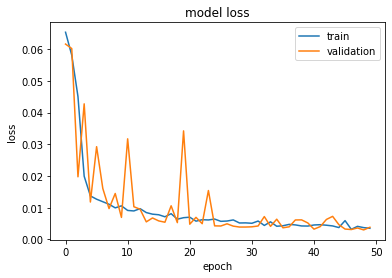

In [19]:
#plot train and validation loss of pretraining
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Show prediction after pretraining ConvAE

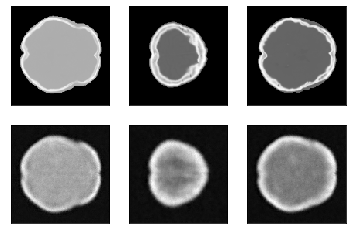

In [20]:
#predict images and display

#number of images to predict
n=3

decoded_imgs = autoencoder.predict(x_test)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from keras.engine.topology import InputSpec

autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

## Inizialize cluster centers using k-means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

## Training

### Deep clustering

In [ ]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
val_loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x_train.shape[0])
index_array_val = np.arange(x_val.shape[0])

tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
import metrics

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y_train is not None:
            acc = np.round(metrics.acc(y_train, y_pred), 5)
            nmi = np.round(metrics.nmi(y_train, y_pred), 5)
            ari = np.round(metrics.ari(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            val_loss = np.round(val_loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss, '; val loss=', val_loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=[p[idx], x_train[idx]])

    idx_val = index_array_val[index * batch_size: min((index+1) * batch_size, x_val.shape[0])]
    val_loss = model.test_on_batch(x=x_val[idx_val], y=[p[idx_val], x_val[idx_val]])
    
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Final evaluation

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

# Eval.
q, _ = model.predict(x_test, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y_test is not None:
    acc = np.round(metrics.acc(y_test, y_pred), 5)
    nmi = np.round(metrics.nmi(y_test, y_pred), 5)
    ari = np.round(metrics.ari(y_test, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

### Plotting clusters

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10_10
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 
from io import BytesIO
from PIL import Image
import base64
def embeddable_image(data):
    data = data[:,:,0]
    buffer = BytesIO()
    plt.imsave(buffer, data, cmap='gray')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

import pandas as pd

emb = model.predict(x_test)[0]
digits_df = pd.DataFrame(emb, columns=('x', 'y','z'))
digits_df['labels'] = [str(i) for i in y_test]
digits_df['image'] = list(map(embeddable_image, list(x_test)))
#digits_df['image_name'] = [dset_train.x_name[i] for i in range(len(dset_train))]
digits_df = digits_df
datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=['0', '1', '2'],
                                       palette=Category10_10)
plot_figure = figure(
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)
plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 1px 1px 1px 1px'/>
    </div>
    <div>
        <span style='font-size: 13px'>@labels</span>
    </div>
</div>
"""))
plot_figure.circle(
    'x',
    'y',
    source=ColumnDataSource(digits_df),
    color=dict(field='labels', transform=color_mapping)
    )
#plot_figure.cross(
#    x=centers[:,0],
#    y=centers[:,1],
#    size=20,
#    line_width=2
#)

#plot_figure.legend.location = "top_left"
#plot_figure.legend.click_policy="hide"
show(plot_figure)

### Show prediction after final training

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

#predict images and display

#number of images to predict
n=2

decoded_imgs = autoencoder.predict(x_test)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Confusion matrix

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y_test], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind